In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

In [2]:
# Image and training settings
img_height, img_width = 224, 224
batch_size = 32
epochs = 20

In [3]:
# Path to dataset
data_dir = "/kaggle/input/fruit-and-vegetable-disease-healthy-vs-rotten/Fruit And Vegetable Diseases Dataset"


In [ ]:
# Image data generators
#data Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 23431 images belonging to 28 classes.
Found 5846 images belonging to 28 classes.


In [6]:
# Class weights to handle imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weights = dict(enumerate(class_weights))

In [ ]:
# Base model: MobileNetV2

base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3))
base_model.trainable = False  # Freeze base initially


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
# Custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)


In [9]:
# Compile initial (frozen) model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [10]:
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    class_weight=class_weights
)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


386/733 ━━━━━━━━━━━━━━━━━━━━ 3:32 611ms/step - accuracy: 0.5700 - loss: 1.6616

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


733/733 ━━━━━━━━━━━━━━━━━━━━ 601s 800ms/step - accuracy: 0.6657 - loss: 1.2622 - val_accuracy: 0.8844 - val_loss: 0.4240
Epoch 2/5
733/733 ━━━━━━━━━━━━━━━━━━━━ 469s 636ms/step - accuracy: 0.9048 - loss: 0.2916 - val_accuracy: 0.9051 - val_loss: 0.3487
Epoch 3/5
733/733 ━━━━━━━━━━━━━━━━━━━━ 466s 631ms/step - accuracy: 0.9226 - loss: 0.2311 - val_accuracy: 0.9037 - val_loss: 0.3618
Epoch 4/5
733/733 ━━━━━━━━━━━━━━━━━━━━ 463s 628ms/step - accuracy: 0.9279 - loss: 0.1974 - val_accuracy: 0.9112 - val_loss: 0.3154
Epoch 5/5
733/733 ━━━━━━━━━━━━━━━━━━━━ 456s 618ms/step - accuracy: 0.9369 - loss: 0.1806 - val_accuracy: 0.9071 - val_loss: 0.3377


In [11]:
# 🔓 Unfreeze top layers of MobileNetV2 for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:100]:  # Freeze first 100 layers
    layer.trainable = False

In [12]:
# Re-compile with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


In [13]:
# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [14]:
# Fine-tuning
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    class_weight=class_weights,
    callbacks=[lr_scheduler, early_stop]
)

Epoch 1/20
733/733 ━━━━━━━━━━━━━━━━━━━━ 487s 635ms/step - accuracy: 0.8566 - loss: 0.4859 - val_accuracy: 0.8734 - val_loss: 0.5307 - learning_rate: 1.0000e-04
Epoch 2/20
733/733 ━━━━━━━━━━━━━━━━━━━━ 463s 628ms/step - accuracy: 0.9523 - loss: 0.1301 - val_accuracy: 0.9146 - val_loss: 0.3435 - learning_rate: 1.0000e-04
Epoch 3/20
733/733 ━━━━━━━━━━━━━━━━━━━━ 467s 632ms/step - accuracy: 0.9638 - loss: 0.1057 - val_accuracy: 0.9285 - val_loss: 0.2809 - learning_rate: 1.0000e-04
Epoch 4/20
733/733 ━━━━━━━━━━━━━━━━━━━━ 460s 623ms/step - accuracy: 0.9745 - loss: 0.0813 - val_accuracy: 0.9466 - val_loss: 0.2232 - learning_rate: 1.0000e-04
Epoch 5/20
733/733 ━━━━━━━━━━━━━━━━━━━━ 461s 623ms/step - accuracy: 0.9797 - loss: 0.0550 - val_accuracy: 0.9483 - val_loss: 0.1930 - learning_rate: 1.0000e-04
Epoch 6/20
733/733 ━━━━━━━━━━━━━━━━━━━━ 466s 631ms/step - accuracy: 0.9818 - loss: 0.0533 - val_accuracy: 0.9530 - val_loss: 0.2050 - learning_rate: 1.0000e-04
Epoch 7/20
733/733 ━━━━━━━━━━━━━━━━━━━━ 

In [15]:
# Final evaluation
loss, accuracy = model.evaluate(val_gen)
print(f"\n✅ Final Fine-Tuned Accuracy: {accuracy*100:.2f}% | Loss: {loss:.4f}")

183/183 ━━━━━━━━━━━━━━━━━━━━ 93s 505ms/step - accuracy: 0.9015 - loss: 0.3917

✅ Final Fine-Tuned Accuracy: 95.04% | Loss: 0.1970


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


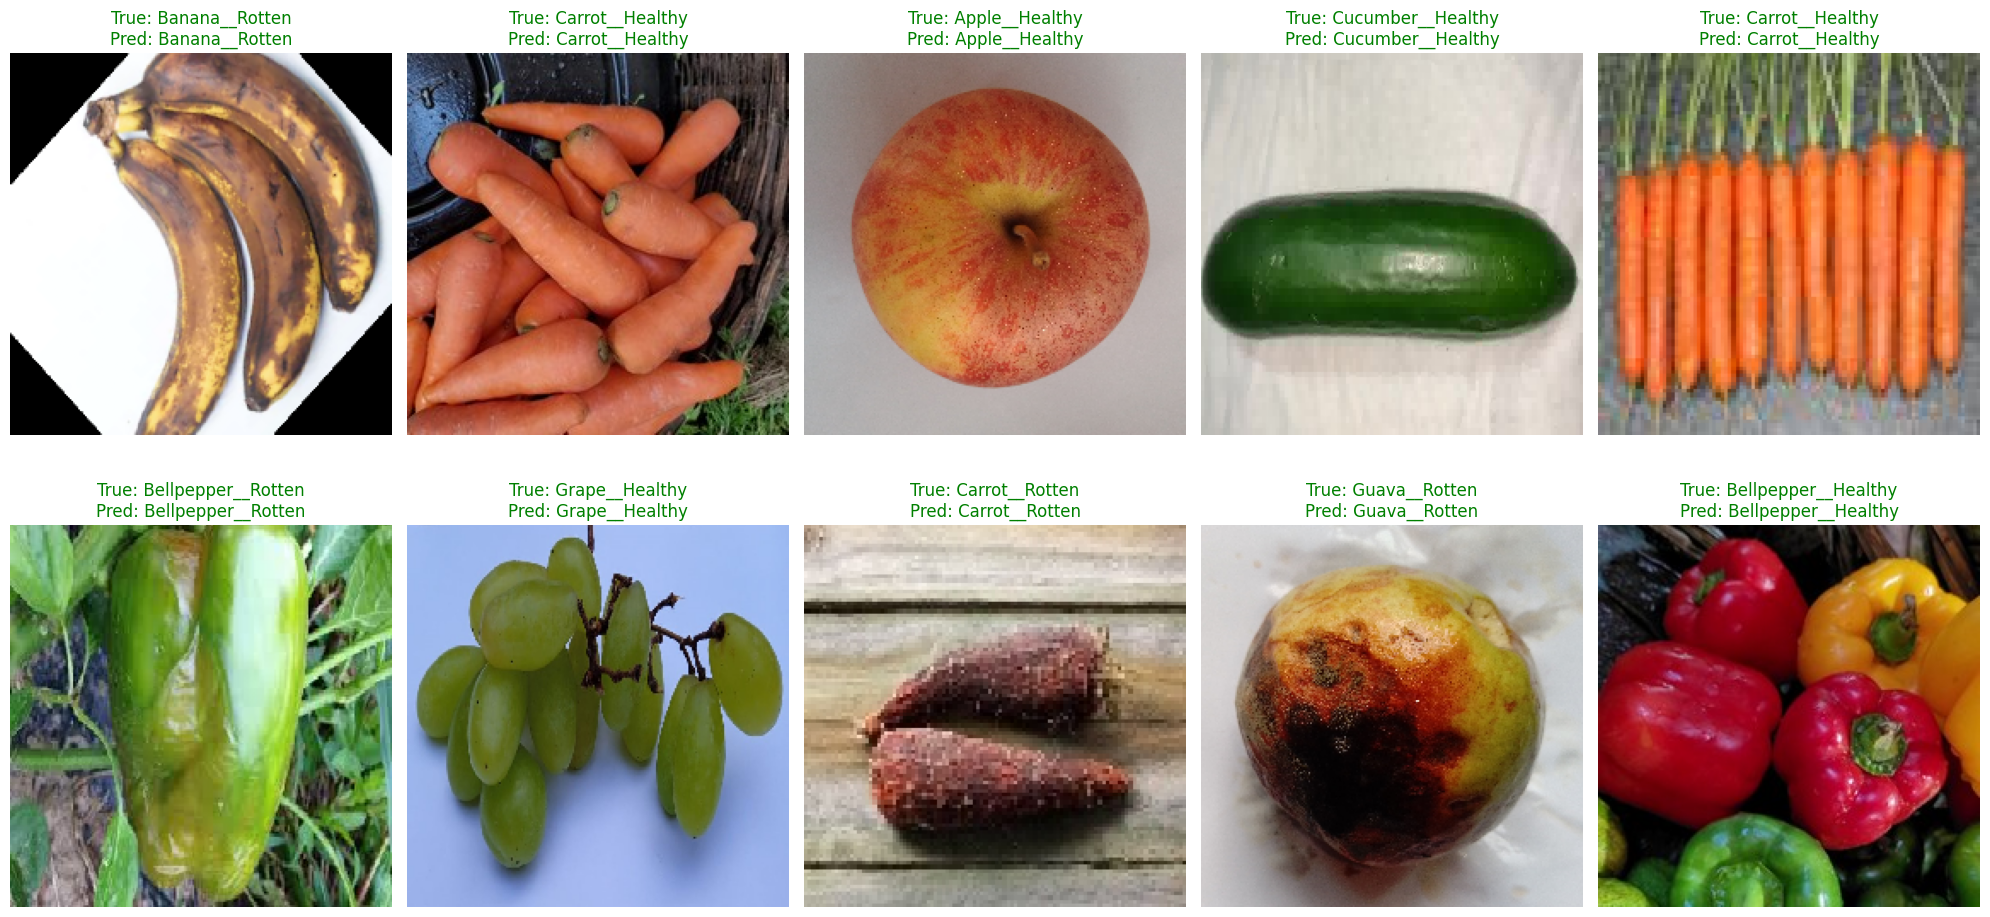

In [16]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import random

# Dataset path again
data_dir = "/kaggle/input/fruit-and-vegetable-disease-healthy-vs-rotten/Fruit And Vegetable Diseases Dataset"

# Get all class directories (like Apple_Healthy, Banana_Rotten, etc.)
all_classes = os.listdir(data_dir)
all_classes = [cls for cls in all_classes if os.path.isdir(os.path.join(data_dir, cls))]

# Randomly select 10 images from the entire dataset
num_images = 10
selected_images = []

for _ in range(num_images):
    class_name = random.choice(all_classes)
    class_path = os.path.join(data_dir, class_name)
    image_name = random.choice(os.listdir(class_path))
    image_path = os.path.join(class_path, image_name)
    selected_images.append((image_path, class_name))

# Display predictions
plt.figure(figsize=(20, 10))

for idx, (img_path, true_label) in enumerate(selected_images):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img) / 255.0
    img_array_expanded = np.expand_dims(img_array, axis=0)

    # Predict
    prediction = model.predict(img_array_expanded)
    predicted_label = list(train_gen.class_indices.keys())[np.argmax(prediction)]

    # Choose color
    color = 'green' if predicted_label == true_label else 'red'

    # Show image
    plt.subplot(2, 5, idx + 1)
    plt.imshow(img_array)
    plt.axis('off')
    plt.title(f"True: {true_label}\nPred: {predicted_label}", color=color)

plt.tight_layout()
plt.show()

In [17]:
model.save('/kaggle/working/fruit_model.h5')
!zip -r /kaggle/working/fruit_model.zip /kaggle/working/fruit_model.h5

  adding: kaggle/working/fruit_model.h5 (deflated 10%)
